In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

you are using nologin method, data you access may be limited


In [97]:
cpi = tv.get_hist(
    symbol = 'USCPI',
    exchange = 'ECONOMICS',
    n_bars = 1200,
    interval = Interval.in_daily
)
cpi.index = pd.to_datetime(cpi.index.strftime('%Y-%m-%d'))

In [98]:
cpi_yoy = cpi['close'].resample('ME').ffill().pct_change(12)

<Axes: xlabel='datetime'>

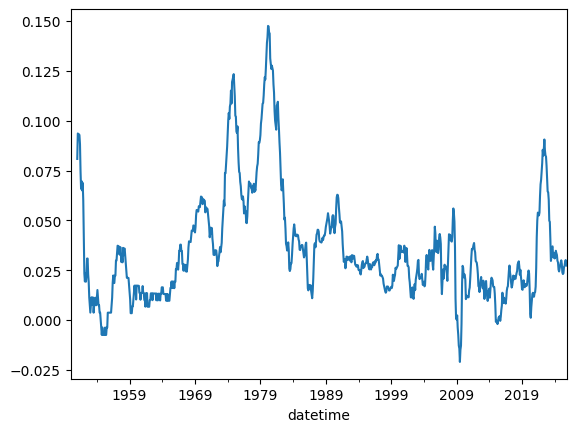

In [99]:
cpi_yoy.plot()

In [104]:
oil = tv.get_hist(
    symbol = 'WTI',
    exchange = 'CFI',
    n_bars = 10000,
    interval = Interval.in_daily
)
oil.index = pd.to_datetime(oil.index.strftime('%Y-%m-%d'))

In [119]:
oil_month = oil['close'].resample('ME').last().ffill()
oil_yoy = oil_month.pct_change(12, fill_method=None)

<Axes: >

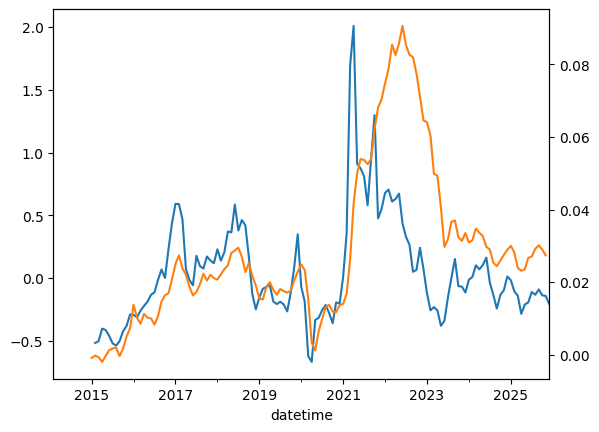

In [120]:
oil_yoy.plot()
cpi_yoy.loc['2015':].plot(secondary_y=True)

In [121]:
mbs = tv.get_hist(
    symbol="MORTGAGE30US",
    exchange="FRED",
    n_bars = 15000,
    interval = Interval.in_daily
)
mbs.index = pd.to_datetime(mbs.index.strftime('%Y-%m-%d'))

In [122]:
mbs_month = mbs['close'].resample('ME').last()
mbs_yoy = mbs_month.diff(12)

<Axes: >

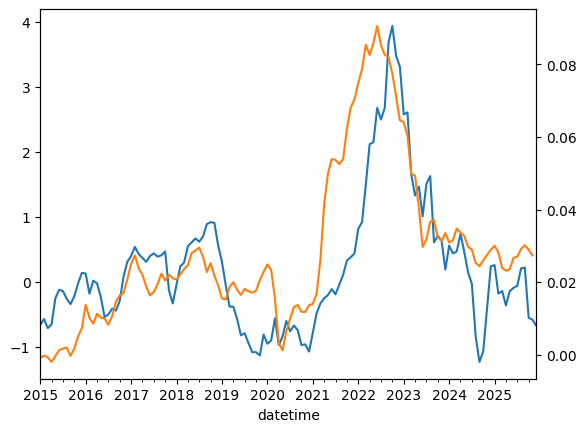

In [123]:
mbs_yoy.loc['2015':].plot()
cpi_yoy.loc['2015':].plot(secondary_y=True)

In [124]:
bei = tv.get_hist(
    symbol="T5YIE",
    exchange="FRED",
    n_bars = 15000,
    interval = Interval.in_daily
)
bei.index = pd.to_datetime(bei.index.strftime('%Y-%m-%d'))

In [125]:
cpi_yoy

datetime
1950-01-31         NaN
1950-02-28         NaN
1950-03-31         NaN
1950-04-30         NaN
1950-05-31         NaN
                ...   
2025-07-31    0.027055
2025-08-31    0.029161
2025-09-30    0.030130
2025-10-31    0.028955
2025-11-30    0.027354
Freq: ME, Name: close, Length: 911, dtype: float64

<Axes: >

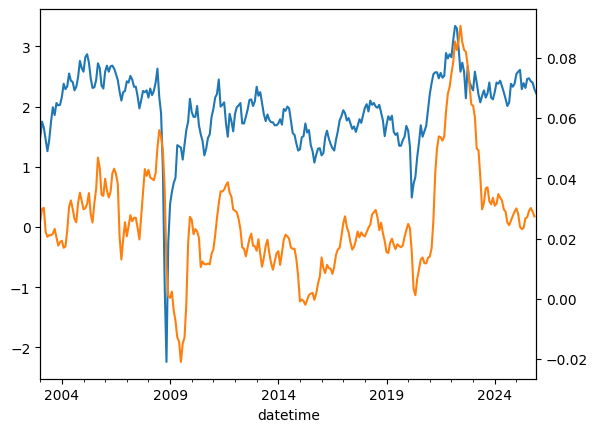

In [126]:
bei['close'].resample('ME').last().plot()
cpi_yoy.loc['2003':].plot(secondary_y=True)

### CPI Modeling

In [148]:
feature_matrix = pd.concat(
    [
        oil_yoy,
        mbs_yoy,
        bei['close'].resample('ME').last(),
    ],axis = 1
).loc['2015-02':'2025-11']
feature_matrix.columns = ['OIL YoY','MBS YoY','BEI']

In [149]:
import statsmodels.api as sm

# X = sm.add_constant(
#     feature_matrix
# )
X = feature_matrix.copy()
y = cpi_yoy.loc['2015-02':]
y.name = 'CPI YoY'

model = sm.OLS(y, X).fit()

In [150]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                CPI YoY   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.926
Method:                 Least Squares   F-statistic:                              544.2
Date:                Sat, 27 Dec 2025   Prob (F-statistic):                    2.81e-72
Time:                        16:41:16   Log-Likelihood:                          417.97
No. Observations:                 130   AIC:                                     -829.9
Df Residuals:                     127   BIC:                                     -821.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<Axes: xlabel='datetime'>

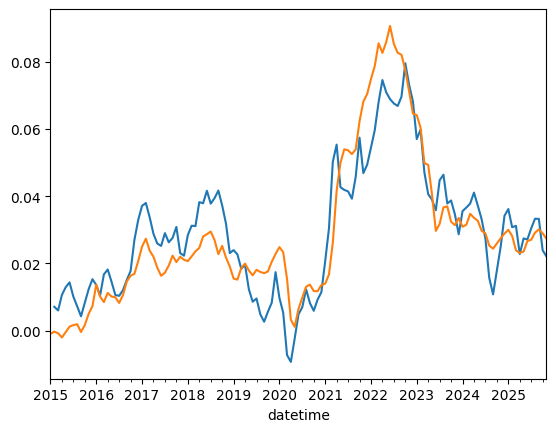

In [151]:
model.fittedvalues.plot()
cpi_yoy.loc['2015':].plot()

In [152]:
model.params

OIL YoY    0.012027
MBS YoY    0.011037
BEI        0.013195
dtype: float64

### Daily CPI Proxy

$$
OIL^{YoY}_t = \log(OIL_t) - \log(OIL_{t-252})
$$
$$
MBS^{YoY}_t = MBSY_t - MBSY_{t-252}
$$
$$
I_t = \beta_1 OIL^{YoY}_t + \beta_2 MBS^{YoY}_t + \beta_3 BEI_t
$$

In [132]:
concat_features = pd.concat(
    [
        oil['close'],
        mbs['close'],
        bei['close']
    ], axis = 1
).loc['2014-02-26':].ffill()
concat_features.columns = ['OIL','MBS','BEI']

In [135]:
oil_yoy_daily = concat_features['OIL'].pct_change(252,fill_method = None)

In [136]:
mbs_yoy_daily = concat_features['MBS'].diff(252)

In [164]:
daily_cpi_proxy = (
    (oil_yoy_daily * model.params['OIL YoY']) +
    (mbs_yoy_daily * model.params['MBS YoY']) +
    (concat_features['BEI'] * model.params['BEI'])
)
daily_cpi_proxy.name = 'CPI_proxy'

In [166]:
pd.DataFrame(daily_cpi_proxy).to_parquet('daily_cpi_proxy.parquet')

<Axes: xlabel='datetime'>

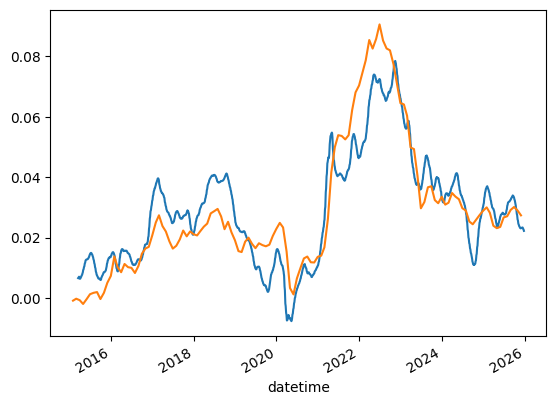

In [161]:
(
    (oil_yoy_daily * model.params['OIL YoY']) +
    (mbs_yoy_daily * model.params['MBS YoY']) +
    (concat_features['BEI'] * model.params['BEI'])
).rolling(20).mean().plot()
cpi_yoy.loc['2015':].plot()